In [340]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_pos_timestamp,get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

from spectral_connectivity.statistics import fisher_z_transform
from spectral_connectivity.statistics import coherence_bias

from coherence import (multitaper_and_connectivity,multitaper_and_connectivity_power)

import statistics 
import matplotlib.patches as mpatches



In [2]:
nwb_file_name = 'senor20201030_.nwb'

In [289]:
#get dfs with position info (head pos, speed), and also linear position 

from spyglass.common.common_position import (IntervalLinearizedPosition, IntervalPositionInfo, TrackGraph)

position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 8 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

linear_position_df= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_file_name,
                      'interval_list_name': 'pos 8 valid times',
                      'track_graph_name': 'senor20201030',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()
linear_position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.604083e+09,NaN,0,NaN,NaN
1.604083e+09,NaN,0,NaN,NaN
1.604083e+09,NaN,0,NaN,NaN
1.604083e+09,NaN,0,NaN,NaN
1.604083e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.604084e+09,325.404045,2,184.106976,208.874099
1.604084e+09,325.404045,2,184.106976,208.874099
1.604084e+09,325.404045,2,184.106976,208.874099


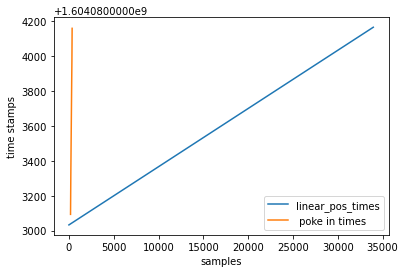

In [299]:
#this cell will plot the times from the two sources- position and timestamps from behavior df, to make sure they overlap. 

plt.plot(linear_position_df.index,label='linear_pos_times')
plt.plot( trial_data_sesh.poke_in_ts, label =' poke in times')
plt.ylabel('time stamps')
plt.xlabel('samples')
plt.legend()

In [290]:
#do the shift/ not equal to method to find the rows when the rat switches track segments

linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())

In [291]:
linear_position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position,track_segment_id_switch
time,,,,,
1.604083e+09,NaN,0,NaN,NaN,True
1.604083e+09,NaN,0,NaN,NaN,False
1.604083e+09,NaN,0,NaN,NaN,False
1.604083e+09,NaN,0,NaN,NaN,False
1.604083e+09,NaN,0,NaN,NaN,False
...,...,...,...,...,...
1.604084e+09,325.404045,2,184.106976,208.874099,False
1.604084e+09,325.404045,2,184.106976,208.874099,False
1.604084e+09,325.404045,2,184.106976,208.874099,False


In [292]:
#find the times (index of this df) when switch == True- theres are the times of the segment switch  

seg_switch_times = linear_position_df[linear_position_df.track_segment_id_switch==True].index

In [293]:
seg_switch_times

Float64Index([1604083032.6807556, 1604083034.9893768, 1604083047.2559314,
              1604083047.6225836,  1604083052.855864,  1604083061.022454,
              1604083062.6890955,  1604083064.122421, 1604083065.0224078,
              1604083088.1888566,
              ...
               1604084106.878658, 1604084114.3452604, 1604084124.8784764,
              1604084128.0451055,  1604084135.778368, 1604084139.1116755,
               1604084146.878263, 1604084151.2782195, 1604084158.2781453,
              1604084163.7114258],
             dtype='float64', name='time', length=236)

In [220]:
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
180,senor20201030_.nwb,4,0,4,B,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
181,senor20201030_.nwb,4,1,3,B,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
182,senor20201030_.nwb,4,2,1,A,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
183,senor20201030_.nwb,4,3,2,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
184,senor20201030_.nwb,4,4,1,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,senor20201030_.nwb,4,175,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
356,senor20201030_.nwb,4,176,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
357,senor20201030_.nwb,4,177,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
358,senor20201030_.nwb,4,178,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [294]:
# this cell will import the behavior csv, turn it into df. will look at only 1 epoch (named trial data sesh)
# Will do some manipulations, like find rows when rat switches stems. and set the first 


filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'

trial_data = pd.read_csv(filename)
trial_data
trial_data_sesh = trial_data[trial_data.epoch==4]

#This will currently label the row that he does the stem switch. If we goes from B-A, it will label the first A trial as true. This can be changed to the one right before, which it used to be for some purposes which i dont currently remember. 
trial_data_sesh['stem_switch'] = trial_data_sesh['stem'].ne(trial_data_sesh['stem'].shift())

#will also set the first trial of every session to be a stem switch
for ix in range(trial_data_sesh.index.min(), trial_data_sesh.index.max()+1):
    
    if trial_data_sesh.loc[ix,'trial_number_by_epoch']==0:
        trial_data_sesh.loc[ix,'stem_switch']= True
    #not sure if this does anything? 
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
180,senor20201030_.nwb,4,0,4,B,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
181,senor20201030_.nwb,4,1,3,B,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
182,senor20201030_.nwb,4,2,1,A,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
183,senor20201030_.nwb,4,3,2,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
184,senor20201030_.nwb,4,4,1,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,50,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,senor20201030_.nwb,4,175,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
356,senor20201030_.nwb,4,176,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
357,senor20201030_.nwb,4,177,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
358,senor20201030_.nwb,4,178,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [300]:
#This makes a list of all trials RUN times.. the end of previous poke to start of next poke
trial_times=[]
for ix in range(1,len(trial_data_sesh)):
    trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
    trial_end = trial_data_sesh.iloc[ix].poke_in_ts
    trial_times.append([trial_start, trial_end])


In [301]:
trial_start

1604084156.7732546

In [302]:
seg_switch_times

Float64Index([1604083032.6807556, 1604083034.9893768, 1604083047.2559314,
              1604083047.6225836,  1604083052.855864,  1604083061.022454,
              1604083062.6890955,  1604083064.122421, 1604083065.0224078,
              1604083088.1888566,
              ...
               1604084106.878658, 1604084114.3452604, 1604084124.8784764,
              1604084128.0451055,  1604084135.778368, 1604084139.1116755,
               1604084146.878263, 1604084151.2782195, 1604084158.2781453,
              1604084163.7114258],
             dtype='float64', name='time', length=236)

In [303]:
#Then, find each segment switch time that falls inbetween trial start and stop times. 
#find which time in segment switch time lists falls between poke pout/poke in, make indiciator, get the single time, then add it to another list 
trials_seg_switch_times = []
for ix in range(len(trial_times)):
    #one inidividual trials start and end times 
    trial_start = trial_times[ix][0]
    trial_end = trial_times[ix][1]
    #find the segment switch time that falls within those trial times 
    switch_time_ind_s = seg_switch_times>=trial_start
    switch_time_ind_e = seg_switch_times<=trial_end
    trial_switch_times = seg_switch_times[switch_time_ind_s & switch_time_ind_e]
    #make it into a new list- for each trial, each now has a list of 1+ segment switch times  
    trials_seg_switch_times.append(trial_switch_times)

In [255]:
trial_start
trial_end

1604084159.1652546

In [256]:
seg_switch_times

Float64Index([1604098281.1621869,  1604098283.201511, 1604098288.0681329,
              1604098288.2014532, 1604098299.9013414,  1604098303.801308,
              1604098323.2344358, 1604098323.9344482, 1604098324.6344268,
              1604098325.9010882,
              ...
              1604099352.2908287,  1604099360.224066, 1604099367.9240086,
              1604099371.2572916, 1604099378.5905683, 1604099381.6238663,
              1604099385.0238218, 1604099388.0904658, 1604099395.1570504,
              1604099402.9236453],
             dtype='float64', name='time', length=238)

In [304]:
#should be 179 for this senor epoch- firrt trial doesnt count. 
len(trials_seg_switch_times)

179

In [393]:

list_seg_switch=[]
#add a 0 to make it the same length as the df 
list_seg_switch.append(0)

for ix in range(len(trials_seg_switch_times)):
    seg_switch_times = trials_seg_switch_times[ix]
    if len(seg_switch_times)==1:
        list_seg_switch.append([seg_switch_times[0]])
    else: 
        list_seg_switch.append(seg_switch_times[0:].tolist())

180

In [306]:
# Then, a hacky way to do this.. If there is only one time for a given trial, add it to new list. if theres more than one, add a zero. 
#this should be 180 in length now. So we can add it to trial data sesh df
#how i should do this later is to just each the list of times to the list, and add them all to the df

# list_of_1_seg_switch=[]
# #add a 0 to make it the same length as the df 
# list_of_1_seg_switch.append(0)

# for ix in range(len(trials_seg_switch_times)):
#     seg_switch_times = trials_seg_switch_times[ix]
#     if len(seg_switch_times)==1:
#         list_of_1_seg_switch.append(seg_switch_times[0])
#     else: 
#         list_of_1_seg_switch.append(0)

In [398]:
#adding this list as a column in the trial_data df 
trial_data_sesh['seg_switch_times'] = list_seg_switch
# trial_data_sesh['seg_switch_times'] = list_of_1_seg_switch
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,seg_switch_times
180,senor20201030_.nwb,4,0,4,B,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
181,senor20201030_.nwb,4,1,3,B,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604083102.8553736]
182,senor20201030_.nwb,4,2,1,A,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[1604083110.5219603, 1604083111.288621, 160408..."
183,senor20201030_.nwb,4,3,2,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604083122.6884935]
184,senor20201030_.nwb,4,4,1,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604083131.2884257]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,senor20201030_.nwb,4,175,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604084135.778368]
356,senor20201030_.nwb,4,176,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604084139.1116755]
357,senor20201030_.nwb,4,177,4,B,0,1.604084e+09,NaN,NaN,1.604084e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604084146.878263]
358,senor20201030_.nwb,4,178,3,B,1,1.604084e+09,1.604084e+09,1.604084e+09,1.604084e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,[1604084151.2782195]


In [399]:
#now we can get only the STAY trials leaf segment switch change times. These times are what well use for multitaper analysis 
stay_trial_seg_switch_times = trial_data_sesh[trial_data_sesh.stem_switch==False].seg_switch_times

In [402]:
(stay_trial_seg_switch_times.iloc[0])[0]

1604083102.8553736

Text(0.5, 1.0, 'position during trials I am using for coherence calculations\n n_trials = 164')

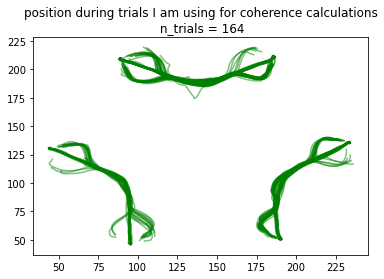

In [404]:
#now, we check that these are indeed only stay trials. We want them to be stay bc if switch, then second after segment switch is another seg switch which could have high coherence 

times = stay_trial_seg_switch_times
for ix in range(0,len(times)): 
    time_start = (times.iloc[ix])[0]-1
    time_end = (times.iloc[ix])[0]+1.5
    x_pos,y_pos = get_pos_timestamp(time_start,time_end,position_info)
    plt.plot(x_pos,y_pos, color= 'g',alpha=.5)
plt.title(f'position during trials I am using for coherence calculations\n n_trials = {len(times)}')

In [20]:
#use this function to go get the eseries data for later use. helps to just to this loading once, and masking later. 

lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
# raw_timestamps, raw_data, raw_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['raw'])

theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])

In [21]:
# These functions will get the electrode ids that were originally used to get the LFP, so that we can use all available 
#data for the coherence analysis 

lfp_electrode_ids =get_electrode_ids(nwb_file_name, which_elects =4, ref=True)

#remove permanently dead tetrode channels. (the ones above tet 24).
lfp_electrode_ids = remove_dead_tet_chans(nwb_file_name, lfp_electrode_ids, perm_dead_chan=96)
lfp_electrode_ids

check_for_dead_probes(nwb_file_name, lfp_electrode_ids)

#look at dead tetrodes that actually could have existed, make sure another electrode from the tet is represented
#If the dead channel is not in our list of electrodes, print none. 
#in testing, none of dead ones were the first in the electrode group, so need to test with a working case when i need it. 
lfp_electrode_ids = checking_other_dead_tets(nwb_file_name,lfp_electrode_ids)

original electrode ids, minus ref = [  0   4  40  44  48  52  56  60  64  68  72  76   8  80  84  88  92  96
 100 104 108 112 116  12 120 124 128 132 136 140 144 148 152 156 160 164
 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236
 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308
 312 316 320 324 328 332 336 340 344 348 352 356 360 364 368 372 376 380
  16  20  24  28  32  36]
added references = [ 17  48  64 288]
lfp electrode ids, plus references = [  0   4   8  12  16  17  20  24  28  32  36  40  44  48  52  56  60  64
  68  72  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136
 140 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208
 212 216 220 224 228 232 236 240 244 248 252 256 260 264 268 272 276 280
 284 288 292 296 300 304 308 312 316 320 324 328 332 336 340 344 348 352
 356 360 364 368 372 376 380]
removing [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 1

In [408]:
#This finds only the stay trials, and nly when theres one segment switch 
times1=[]
for ix in range(len(times)):
    time=times.iloc[ix]
    if len(time) <2:
        times1.append(time)

In [415]:
len(times)
len(times1)

163

In [409]:
#this is the time to be used for plotting later. 
#note, data goes from -1.5 to +1, and the points are the middle of the time windows for the coherence. e.g.- -1.5:-1's time = -1.25 

x= [i for i in np.arange(-1.25,1,0.5)]

In [413]:
#this is just to set the cutoff between hpc and pfc electrodes.. the cuttoff here is the length of the hpc electrodes. 

hpc_elecs_to_see=[]
pfc_elecs_to_see=[]

hpc_pfc_cutoff_ix = 25
for ix in range(0,hpc_pfc_cutoff_ix):
    hpc_elecs_to_see.append(lfp_electrode_ids[ix])
for ix in range(hpc_pfc_cutoff_ix,len(lfp_electrode_ids)):
    pfc_elecs_to_see.append(lfp_electrode_ids[ix])
print(hpc_elecs_to_see)
print(pfc_elecs_to_see)

[0, 4, 8, 12, 16, 17, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92]
[128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380]


In [57]:
#This is to check out the electrode pairs that will be used, in the same order to seperate later 

electrode_ids_save=[]
for hpc_elecs in range(0,25):
    # temp_signal[:,:,0] = signal[:,:, hpc_elecs]   
    for elec in range(25,len(lfp_electrode_ids)):
        electrode_ids_save.append ([lfp_electrode_ids[hpc_elecs],lfp_electrode_ids[elec]])

In [421]:
len(electrode_ids_save)

1600

In [318]:
#This cell makes a structure names signal, which has ell electrodes, all stay trials. more efficient than doing all pairs of electrodes and running coherence seprately 


#NOTE- still takes a little bit to run- maybe ~10 minutes. 

n_signals = len(lfp_electrode_ids)
signal = np.zeros((int(n_time_samples), n_trials, n_signals))
n_trials = len(times1)

for ix in range(len(times1)): 
        #because the switch trials have 0 instead of a seg switch time.. so if it doesnt, grab the data for the trial,
        if times1[ix] != 0.0:
                #these +- times are hard coded for now, can change how much time around each segment time you want to look at but also much change num_s above
            time_start =times1[ix]-1.5
            time_end = times1[ix]+1
                # this functions will take the times and the eseries etc and will mask them and return the data for all electrodes in electrode id
            x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, lfp_electrode_ids, lfp_eseries, lfp_timestamps, lfp_data)

        #         #this is because some of the trials are missing one sample. so if they are, i append a 0. 
        #         #This is probably not the best way to do this, and I want to investigate why this is happening. 
            if len(y_elect_lfp_eg1[0]) != n_time_samples: 
                #figure out how many zeroes to add to the end
                num_zeros = n_time_samples - len(y_elect_lfp_eg1[0])
                y_elect_lfp_eg1[:] = np.pad(y_elect_lfp_eg1[:], (0, int(num_zeros)), 'constant')
# now save all trials lfp for all electrodes in signal.
            for elecs in range(len(lfp_electrode_ids)): 
                # signal has the lfp filtered data for all trials for all electrodes 
                signal[:,ix,elecs] = (y_elect_lfp_eg1[elecs])



In [314]:
signal.shape

(2500, 152, 89)

In [489]:
#This cell will do the coherence calculations using a function. 
# will grab all trials lfp data for 1 hpc elec and 1 pfc elec and will pass it into the coherence calculator, then add only the 8hz coherence results
#into a list

coher_keeper = []

sampling_rate=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None

num_sec = 2.5
n_trials = len(times1)
n_signals= 2
n_time_samples = (num_sec*sampling_rate)

# inititalize "temp_signal" which will contain all trials for only 2 signals 
temp_signal = np.zeros((int(n_time_samples), n_trials, n_signals))

for hpc_elecs in range(0,25):
    #temp signal, all trials, 1 electrode, one of the 25 hpc electrodes (0,24, plus an extra ref)
    temp_signal[:,:,0] = signal[:,:, hpc_elecs]   
    
    for elec in range(25,len(lfp_electrode_ids)):
        #for all pfc electrodes
        temp_signal[:,:,1] = signal[:,:,elec]
        #get the coherence magnitude, plus some exrtra stuff
        time, freq, mag, power, n_trials = multitaper_and_connectivity(temp_signal,sampling_rate,time_halfbandwidth_product,time_window_duration,time_window_step)
        #get only the coherence magnitude at 8hz
        coh_8hz = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
        #and save it to list, coher keeper. 
        coher_keeper.append(coh_8hz[0])


        

163

Text(0.5, 1.0, 'epoch 4!!!!')

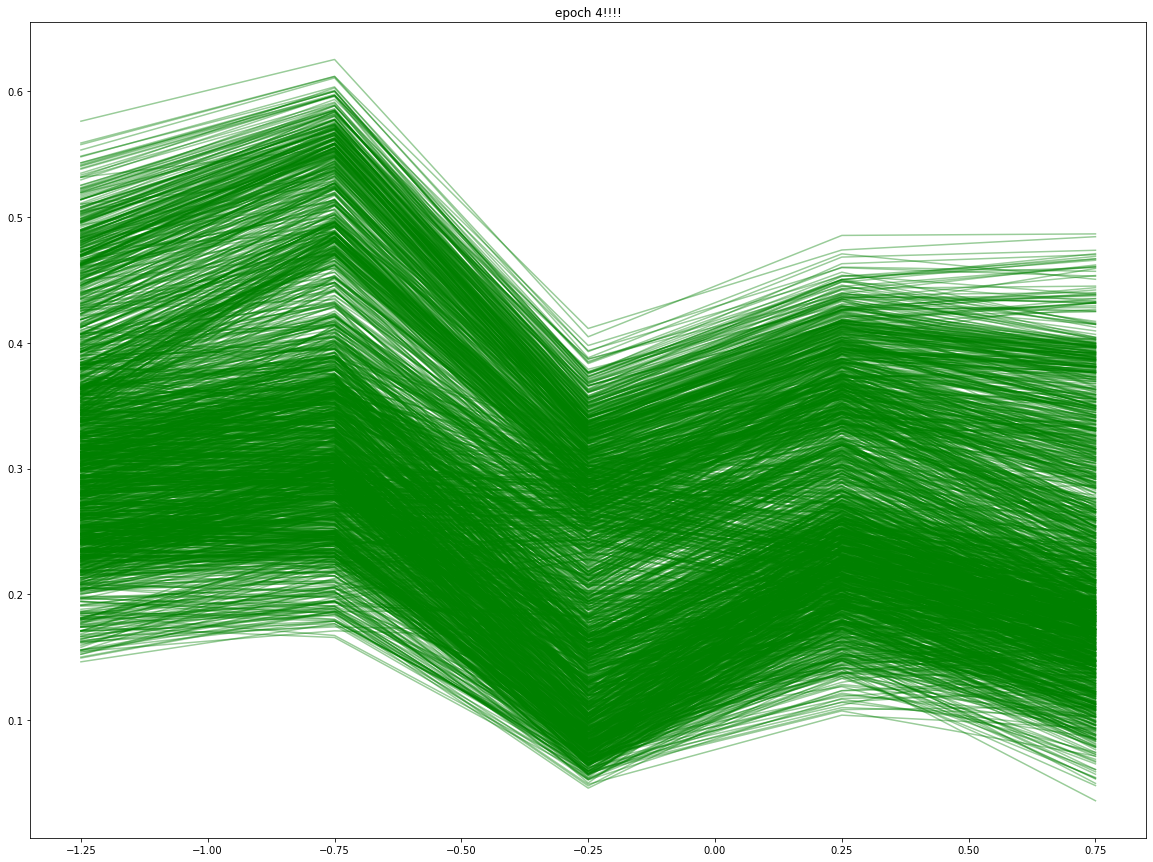

In [490]:
#plot all together, no color coding 
plt.figure(figsize=(20,15))
for ix in range(len(coher_keeper)):
    plt.plot(x,coher_keeper[ix],color='g',alpha = .4)
plt.title('epoch 4!!!!')

In [491]:
#heres the info im working off of to split these up: 

# Tets 1:12 = left (ch 0:44)
# 13:24 = right (48: 92)

# Probes: 
# Probe 1: left pfc -128:252 
# Probe 2: right pfc 256:380

hpc_elec_cutoff_LR = 44
pfc_elec_cutoff_LR = 252

Text(0, 0.5, 'coherence')

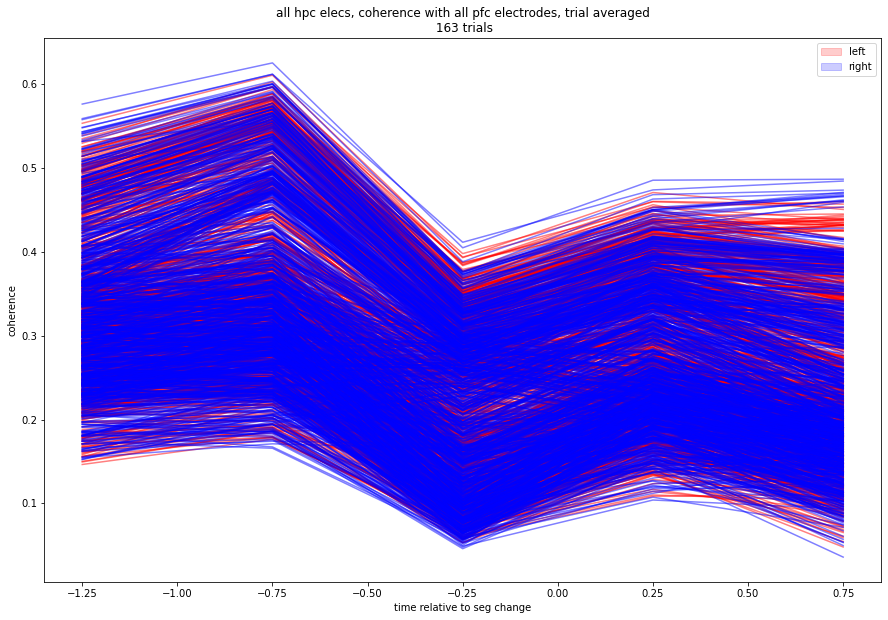

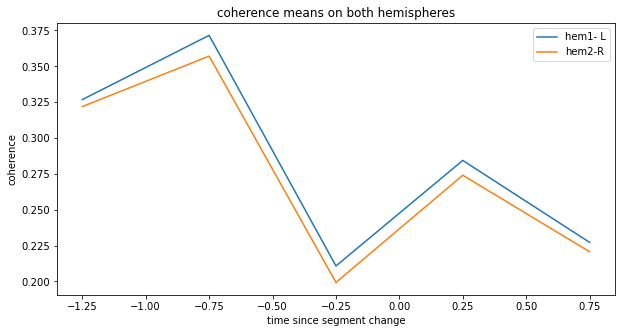

In [492]:
#split by hpc hesmipsheres, but not pfc. just in half, which is not entirely accurate bc theres an extra electrode(ref) in the first hemi group
plt.figure(figsize=(15,10))


coher_keeper_left_hem=[]
coher_keeper_right_hem=[]

for ix in range(len(coher_keeper)):
    #if hpc electrode is under 44, plot it in red. otherwise, plot it blue. 
    if electrode_ids_save[ix][0]<=hpc_elec_cutoff_LR:
        plt.plot(x, coher_keeper[ix], color='r',alpha=.5)
        #and save these to a list to take their means and plot their averages
        coher_keeper_left_hem.append(coher_keeper[ix])
    else: 
        plt.plot(x, coher_keeper[ix], color='blue',alpha=.5)
        coher_keeper_right_hem.append(coher_keeper[ix])
red_patch = mpatches.Patch(color='r', alpha=.2, label='left')
blue_patch = mpatches.Patch(color='blue', alpha=.2, label='right')
plt.legend(handles=[red_patch,blue_patch],loc = 'upper right')               
plt.title(f'all hpc elecs, coherence with all pfc electrodes, trial averaged\n {n_trials} trials')
plt.xlabel('time relative to seg change')
plt.ylabel('coherence')       
        
        
        
        
plt.figure(figsize=(10,5))
mean_hem_1 = np.mean(coher_keeper_hem1,axis=0)
mean_hem_2 = np.mean(coher_keeper_hem2,axis=0)
plt.plot(x,mean_hem_1, label='hem1- L')
plt.plot(x,mean_hem_2,label='hem2-R')
plt.legend()
plt.title('coherence means on both hemispheres')
plt.xlabel('time since segment change')
plt.ylabel('coherence')
        



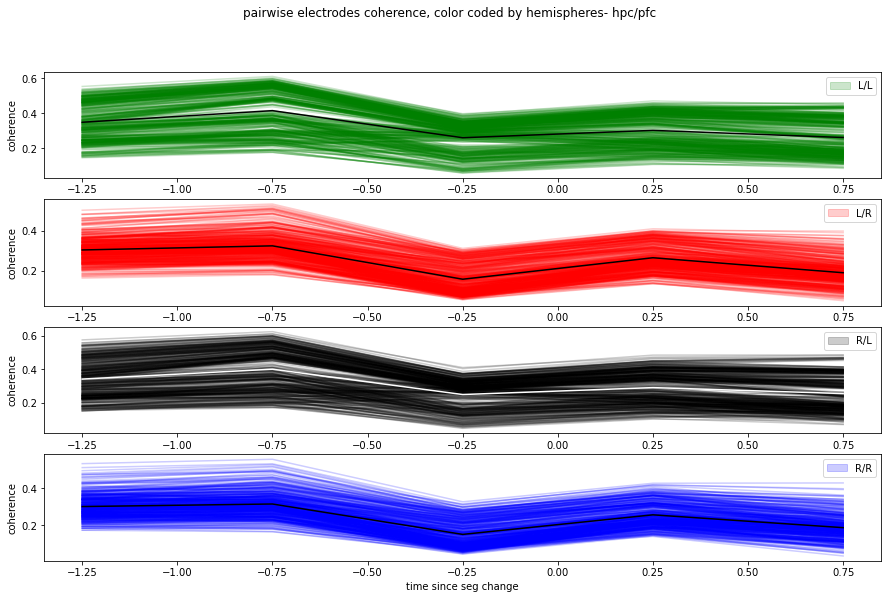

In [493]:
#this cell will make a subplot, looking at the coherence from the L/R hemispheres of both hpc and hpc. 
#LL,LR,RL,RR. 


fig, axes = plt.subplots(nrows=4, figsize=(15, 9))
left_left=[]
left_right=[]
right_left=[]
right_right=[]
for ix in range(len(electrode_ids_save)):
    #if hpc electrodes less than 44, or greater than 44, and pfc electrodes on either side of 252. plot in subplots. 
    if electrode_ids_save[ix][0]<=hpc_elec_cutoff_LR:
        if electrode_ids_save[ix][1]<=pfc_elec_cutoff_LR:
            axes[0].plot(x,coher_keeper[ix],color='green',alpha=.2)
            #and keep these for later to plot their means. 
            left_left.append(coher_keeper[ix])
        if electrode_ids_save[ix][1]>pfc_elec_cutoff_LR:
            axes[1].plot(x,coher_keeper[ix],color='r',alpha=.2)
            left_right.append(coher_keeper[ix])
    if electrode_ids_save[ix][0]>hpc_elec_cutoff_LR:       
        if electrode_ids_save[ix][1]<=pfc_elec_cutoff_LR:
            axes[2].plot(x,coher_keeper[ix],color='black',alpha=.2) 
            right_left.append(coher_keeper[ix])
        if electrode_ids_save[ix][1]>pfc_elec_cutoff_LR:
            axes[3].plot(x,coher_keeper[ix],color='blue',alpha=.2)
            right_right.append(coher_keeper[ix])


#making the legends, because doing do in the for loop doesnt work (makes a new label for every line!) 
green_patch = mpatches.Patch(color='green', alpha=.2, label='L/L')
red_patch = mpatches.Patch(color='r', alpha=.2, label='L/R')
black_patch = mpatches.Patch(color='black', alpha=.2, label='R/L')
p_patch = mpatches.Patch(color='blue', alpha=.2,label='R/R')


axes[0].set_ylabel('coherence')
axes[1].set_ylabel('coherence')
axes[2].set_ylabel('coherence')
axes[3].set_ylabel('coherence')


# plt.xlabel('time since segment change')
fig.suptitle('pairwise electrodes coherence, color coded by hemispheres- hpc/pfc')

axes[0].legend(handles=[green_patch],loc = 'upper right')               
axes[1].legend(handles=[red_patch],loc = 'upper right')               
axes[2].legend(handles=[black_patch],loc = 'upper right')               
axes[3].legend(handles=[p_patch],loc = 'upper right')               

axes[0].set_xlabel('time since seg change')
axes[1].set_xlabel('time since seg change')
axes[2].set_xlabel('time since seg change')
axes[3].set_xlabel('time since seg change')


mean_LL = np.mean(left_left,axis=0)
mean_LR = np.mean(left_right,axis=0)
mean_RL = np.mean(right_left,axis=0)
mean_RR = np.mean(right_right,axis=0)

axes[0].plot(x,mean_LL, color='black',label='LL')
axes[1].plot(x,mean_LR,color='black',label='LR')
axes[2].plot(x,mean_RL, color='white',label='RL')
axes[3].plot(x,mean_RR,color='black',label='RR')

Text(0, 0.5, 'coherence')

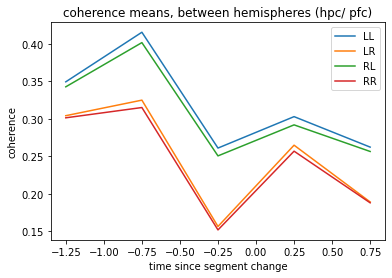

In [494]:
#take their means, and plot. 
mean_LL = np.mean(left_left,axis=0)
mean_LR = np.mean(left_right,axis=0)
mean_RL = np.mean(right_left,axis=0)
mean_RR = np.mean(right_right,axis=0)

plt.plot(x,mean_LL, label='LL')
plt.plot(x,mean_LR,label='LR')
plt.plot(x,mean_RL, label='RL')
plt.plot(x,mean_RR,label='RR')

plt.legend()
plt.title('coherence means, between hemispheres (hpc/ pfc)')
plt.xlabel('time since segment change')
plt.ylabel('coherence')

In [450]:
#note, this is specific to having two probes only. also also having an extra hpc electrode, though it should capture that. 

hpc_elec_cutoff_LR = 44 #between LR hpc
pfc_elec_cutoff_LR = 252 #between LR pfc
pfc_hpc_cutoff = 92 #between 

#the next plots split up electrodes by index, not by value of electrode id, in lfp_electrode ids. so calcualte those indices here. 
#should be the index of hpc and pfc hemispehere cutoffs, and between hpc and pfc electrodes. 
num_elecs_hpc = len(lfp_electrode_ids[lfp_electrode_ids<=pfc_hpc_cutoff])
hpc_hem_cutoff = len(lfp_electrode_ids[lfp_electrode_ids<=hpc_elec_cutoff_LR])
num_elecs_pfc = len(lfp_electrode_ids[lfp_electrode_ids>pfc_hpc_cutoff])
num_elecs_pfc

In [476]:
#now, doing the same thing but to look at the power. Starting with the pfc. 
# split up the data by hemsipehre. 
coher_keeper = []
power_keeper_pfc = []
sampling_rate=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None

num_sec = 2.5
n_trials = len(times1)
n_signals= 1
n_time_samples = (num_sec*sampling_rate)

# inititalize "temp_signal" which will contain all trials for only 2 signals 
temp_signal = np.zeros((int(n_time_samples), n_trials, n_signals))

# for hpc_elecs in range(0,25):
#     #temp signal, all trials, 1 electrode, one of the 25 hpc electrodes (0,24, plus an extra ref)
#     temp_signal[:,:,0] = signal[:,:, hpc_elecs]   
power_keeper_pfc1=[]
power_keeper_pfc2=[]
#do this for each hesmisphere seperately, maybe a way to combine them. 
for elec in range(num_elecs_hpc,num_elecs_hpc+int(num_elecs_pfc/2)):
        temp_signal[:,:,0] = signal[:,:,elec]
        time, freq, power, n_trials = multitaper_and_connectivity_power(temp_signal,sampling_rate,time_halfbandwidth_product,time_window_duration,time_window_step) 
        power_pfc = power()[:,:,0].squeeze().T[(freq[0] == 8)][0]
        power_keeper_pfc1.append(power_pfc)
        # power_keeper_hpc.append(power_hpc)
for elec in range(num_elecs_hpc+int(num_elecs_pfc/2),len(lfp_electrode_ids)):
        temp_signal[:,:,0] = signal[:,:,elec]
        time, freq, power, n_trials = multitaper_and_connectivity_power(temp_signal,sampling_rate,time_halfbandwidth_product,time_window_duration,time_window_step) 
        power_pfc = power()[:,:,0].squeeze().T[(freq[0] == 8)][0]
        power_keeper_pfc2.append(power_pfc)

In [477]:
#same for hpc
coher_keeper = []
sampling_rate=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None

num_sec = 2.5
n_trials = len(times1)
n_signals= 1
n_time_samples = (num_sec*sampling_rate)

# inititalize "temp_signal" which will contain all trials for only 2 signals 
temp_signal = np.zeros((int(n_time_samples), n_trials, n_signals))

# for hpc_elecs in range(0,25):
#     #temp signal, all trials, 1 electrode, one of the 25 hpc electrodes (0,24, plus an extra ref)
#     temp_signal[:,:,0] = signal[:,:, hpc_elecs]   
power_keeper_hpc1=[]
power_keeper_hpc2=[]
for elec in range(0,hpc_hem_cutoff):
        temp_signal[:,:,0] = signal[:,:,elec]
        time, freq, power, n_trials = multitaper_and_connectivity_power(temp_signal,sampling_rate,time_halfbandwidth_product,time_window_duration,time_window_step) 
        power_hpc = power()[:,:,0].squeeze().T[(freq[0] == 8)][0]
        power_keeper_hpc1.append(power_hpc)
        # power_keeper_hpc.append(power_hpc)
for elec in range(hpc_hem_cutoff,25):
        temp_signal[:,:,0] = signal[:,:,elec]
        time, freq, power, n_trials = multitaper_and_connectivity_power(temp_signal,sampling_rate,time_halfbandwidth_product,time_window_duration,time_window_step) 
        power_hpc = power()[:,:,0].squeeze().T[(freq[0] == 8)][0]
        power_keeper_hpc2.append(power_hpc)

Text(0, 0.5, 'power')

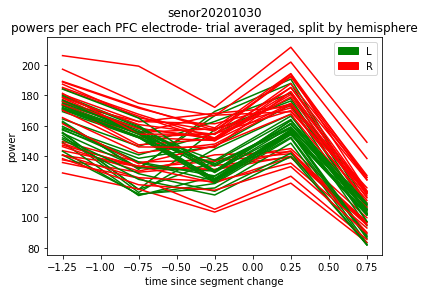

In [487]:
for ix in range(len(power_keeper_pfc1)):
    plt.plot(x,power_keeper_pfc1[ix],color='g')
    plt.plot(x,power_keeper_pfc2[ix], color='r')
green_patch = mpatches.Patch(color='green', alpha=1, label='L')
red_patch = mpatches.Patch(color='r', alpha=1, label='R')
plt.legend(handles=[green_patch,red_patch],loc = 'upper right')               
# 
plt.title(f'{nwb_file_name[:-5]}\npowers per each PFC electrode- trial averaged, split by hemisphere')
plt.xlabel('time since segment change')
plt.ylabel('power')

Text(0, 0.5, 'power')

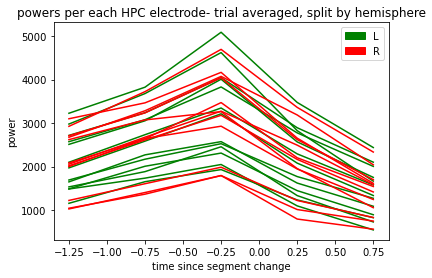

In [483]:
#split up bc for senor the hpc electrodes from each hemisphere are different lengths 
for ix in range(len(power_keeper_hpc1)):
    plt.plot(x,power_keeper_hpc1[ix],color='g')
for ix in range(len(power_keeper_hpc2)):
    plt.plot(x,power_keeper_hpc2[ix], color='r')
green_patch = mpatches.Patch(color='green', alpha=1, label='L')
red_patch = mpatches.Patch(color='r', alpha=1, label='R')
plt.legend(handles=[green_patch,red_patch],loc = 'upper right')               
# 
plt.title(f'{nwb_file_name[:-5]}\npowers per each HPC electrode- trial averaged, split by hemisphere')
plt.xlabel('time since segment change')
plt.ylabel('power')

Text(0, 0.5, 'power')

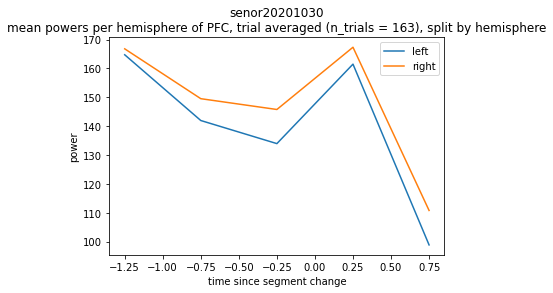

In [486]:
mean_left_hem = np.mean(power_keeper_pfc1,axis=0)
mean_r_hem = np.mean(power_keeper_pfc2,axis=0)
plt.plot(x,mean_left_hem, label = 'left') 
plt.plot(x,mean_r_hem, label = 'right')
plt.legend()
plt.title(f'{nwb_file_name[:-5]}\nmean powers per hemisphere of PFC, trial averaged (n_trials = {n_trials}), split by hemisphere')
plt.xlabel('time since segment change')
plt.ylabel('power')

Text(0, 0.5, 'power')

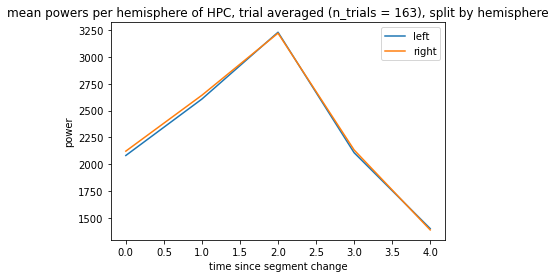

In [481]:
mean_left_hem = np.mean(power_keeper_hpc1,axis=0)
mean_r_hem = np.mean(power_keeper_hpc2,axis=0)
plt.plot(x,mean_left_hem, label = 'left') 
plt.plot(x,mean_r_hem, label = 'right')
plt.legend()
plt.title(f'{nwb_file_name}\nmean powers per hemisphere of HPC, trial averaged (n_trials = {n_trials}), split by hemisphere')
plt.xlabel('time since segment change')
plt.ylabel('power')

In [346]:
len(power_keeper_pfc)

64

In [381]:
Electrode() & {'nwb_file_name':nwb_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
senor20201030_.nwb,0,0,tetrode_12.5,0,0,6,0,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,1,tetrode_12.5,0,1,6,1,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,2,tetrode_12.5,0,2,6,2,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,3,tetrode_12.5,0,3,6,3,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,4,tetrode_12.5,0,0,6,4,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,5,tetrode_12.5,0,1,6,5,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,6,tetrode_12.5,0,2,6,6,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,7,tetrode_12.5,0,3,6,7,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,40,tetrode_12.5,0,0,6,40,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,41,tetrode_12.5,0,1,6,41,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
